#Trabalho de Avaliação e Desempenho

Grupo:<br>
Bruno Hryniewicz - 115150099 <br>
Eduardo da Silva Barbosa - 116150432 <br>
Miguel Bicudo - 116033119 <br>
Nickolas Gomes Pinto - 114148170 <br>
Rafael Pais Cardoso - 116140788 <br>
Tainá da Silva Lima - 116165607 <br>

Professor(a): Daniel Sadoc <br>
Período: 2019.2

##Questão 5

### Código-base para o cálculo analítico

Para todos os cenários e todos os itens para estes cenários é utilizado este código para o cálculo analítico do trabalho pendente e sua média.


In [0]:
#Exponencial Cenário 2
def trabalhoPendenteCenario2_Analitico(λ1, λ2, µ1, µ2):

  ρ = (λ1 * (1/µ1)) + (λ2 * (1/µ2))
  Xr = ((λ1/µ1)/ρ)*(1/µ1) + ((λ2/µ2)/ρ)*(1/µ2)

  if(ρ == 1):
    ρ = 0.99
  U = (ρ*Xr)/(1-ρ)

  return [U, Xr, ρ]


#Determinístico Cenário 3
def trabalhoPendenteCenario3_Analitico(λ1, λ2, µ1, µ2):

  ρ = (λ1 * (1/µ1)) + (λ2 * (1/µ2))
  Xr = ((λ1/µ1)/ρ)*(1/(2*µ1)) + ((λ2/µ2)/ρ)*(1/(2*µ2))

  if(ρ == 1):
    ρ = 0.999

  U = (ρ*Xr)/(1-ρ)
 
  return [U, Xr, ρ]

def X_barra(µ = 0, a = 0, b = 0, tipoServico = 'e'):
  if tipoServico == 'e':
    return 1/µ
  elif tipoServico == 'u':
    return (a+b)/2
  else:
    return 1/µ

def X2_barraFunction(µ = 0, a = 0, b = 0, tipoServico = 'e'):
  if tipoServico == 'e':
    return 2/(pow(µ,2))
  elif tipoServico == 'u':
    return ( pow(a, 2) + a*b + pow(b,2)  )/3
  else:
    return 1/(pow(µ,2))

def NqAnaliticoCenario2(λ1, λ2, µ1, µ2, preempcao):
  resultado = trabalhoPendenteCenario2_Analitico(λ1, λ2, µ1, µ2)
  U = resultado[0]
  Xr = resultado[1]
  ρ = resultado[2]
  ρ1 = λ1/µ1
  Xr1 = (X2_barraFunction(µ1, 0, 0, 'e'))/(2*X_barra(µ1, 0, 0, 'e'))

  if(preempcao):
    W1 = (ρ*Xr)/(1-ρ1)
    W2 = U/(1-ρ1) 
  else:
    W1 = (ρ1*Xr1)/(1-ρ1)
    W2 = U/(1-ρ1)
  return λ1*W1,λ2*W2

def NqAnaliticoCenario3(λ1, λ2, µ1, µ2, preempcao):
  resultado = trabalhoPendenteCenario3_Analitico(λ1, λ2, µ1, µ2)
  U = resultado[0]
  Xr = resultado[1]
  ρ = resultado[2]
  ρ1 = λ1/µ1
  Xr1 = (X2_barraFunction(µ1, 0, 0, 'e'))/(2*X_barra(µ1, 0, 0, 'e'))

  if(preempcao):
    W1 = (ρ*Xr)/(1-ρ1)
    W2 = U/(1-ρ1) 
  else:
    W1 = (ρ1*Xr1)/(1-ρ1)
    W2 = U/(1-ρ1)
  return λ1*W1,λ2*W2 


### Código-base para a impressão dos gráficos

In [0]:
#Imprimir os gráficos

def printGraficoQ5(cenario, item, result, max, ymax):
  plt.figure(figsize= [10, 10])
  
  plt.title ("λ1 x trabalho pendente no cenário " + str(cenario) + " para o item " + item)
  plt.bar(result[0], result[1], width = 0.01, color = 'purple', yerr = result[3], capsize=7,  edgecolor = 'black', align='edge', label='Simulação')
  
  #resultAnalitico = result[2][:len(result[2])-1]
  #resultAnalitico.append(result[1][len(result[1])-1])
  
  plt.bar([ x+0.01 for x in result[0] ], result[2] , width = 0.01, color = 'pink', edgecolor = 'black', align='edge', label='Analítico')
  
  plt.xticks( np.array(range(5, max, 5)) * 0.01 )
  plt.xlabel('λ1', fontsize=15)
  plt.ylabel('E(U)', fontsize=15)
  plt.legend()
  axes = plt.gca()
  #axes.set_xlim([xmin,xmax])
  if (cenario == 3 and item == 'b'):
    axes.set_ylim([-1*ymax,ymax])
  else:
    axes.set_ylim([0,ymax])
 
  plt.show()

### Item a (Fila única)

#### Código-base para a simulação

In [0]:
import numpy as np
import scipy as sp
import scipy.stats
import math
import time
import random
import operator
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from decimal import *

class Eventos:
  def __init__(self, tipo, fimEvento, duracaoServico):
    self.tipo = tipo
    self.fimEvento = fimEvento #Do ponto de vista do lambda é a chegada na fila e do ponto de vista de mi é o tempo de sair do servidor.
    self.duracaoServico = duracaoServico

#Simulador  
def simulaMG1a (λ1, λ2, µ1, µ2, nEventos, X = random.expovariate, tempoTotalSimulacao = 4000): # Simula uma fila M/G/1, retornando o E(N)
  linhaDoTempo = 0
  
  area1 = 0
  N01 = 0
  T01 = 0
  area2 = 0
  N02 = 0
  T02 = 0
  numeroClienteT1 = 0
  numeroClienteT2 = 0
  numeroTotalCliente = 0
  tempTotalServico = 0
  fila = []  #Fila. OBS: A primeira posição representa o servidor, logo o cliente que ocupar tal posição estar no servidor.
  eventos = [] #Fila de eventos
  atualEvento = 0

  #Primeira ocorrência de eventos (λ1 e λ2)
  temp = random.expovariate(λ1)
  eventos.append(Eventos("Chegada1",temp , temp))
  if(λ2 != 0):
    temp = random.expovariate(λ2)
    eventos.append(Eventos("Chegada2", temp, temp))
  

  while(linhaDoTempo <= tempoTotalSimulacao):

    eventos.sort(key=lambda eventos: eventos.fimEvento)

    atualEvento = eventos[0] #Pega o primeiro evento
    eventos = eventos[1:] #Tira o primeiro evento da fila de eventos
    linhaDoTempo = atualEvento.fimEvento #Avança a linha do tempo

    if(atualEvento.tipo == "Chegada1"):
      numeroClienteT1 += 1
      fila.append(1)
      temp = random.expovariate(λ1)
      eventos.append(Eventos("Chegada1", linhaDoTempo + temp, temp))

      if(len(fila) == 1):
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
        numeroClienteT1 -= 1

    elif(atualEvento.tipo == "Chegada2"):
      numeroClienteT2 += 1
      fila.append(2)
      temp = random.expovariate(λ2)
      eventos.append(Eventos("Chegada2", linhaDoTempo +temp, temp))

      if(len(fila) == 1):
        temp =  X(µ2)
        eventos.append(Eventos("Servico2", linhaDoTempo + temp, temp))
        numeroClienteT2 -= 1

    elif(atualEvento.tipo == "Servico1" or atualEvento.tipo == "Servico2"):
      fila = fila[1:]
      numeroTotalCliente += 1
      tempTotalServico += atualEvento.duracaoServico

      if(len(fila) != 0 and fila[0] == 1):
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
      elif(µ2 != 0 and len(fila) != 0 and fila[0] == 2 ):
        temp =  X(µ2)
        eventos.append(Eventos("Servico2", linhaDoTempo + temp, temp))
 
    quantidadeT1 = 0
    quantidadeT2 = 0
    for i in fila:
      if(i == 1):
        quantidadeT1 += 1
      else:
        quantidadeT2 += 1
    
    if(quantidadeT1 != N01):

      if(N01 > 0 ):
        area1 = area1 + (N01-1)*(linhaDoTempo - T01)

      N01 = quantidadeT1
      T01 = linhaDoTempo

    if(quantidadeT2 != N02):

      if(N02 > 0 ):
        area2 = area2 + (N02-1)*(linhaDoTempo - T02)

      N02 = quantidadeT2
      T02 = linhaDoTempo
  
  return area1/linhaDoTempo, numeroTotalCliente, (tempTotalServico/numeroTotalCliente), (tempTotalServico/linhaDoTempo), area2/linhaDoTempo  #Retorna [Nq1], N, [X], ρ, [Nq2] 

#Chama o simulador diversas vezes e gera a média dos resultados
def simulaGerala(λ1, λ2, µ1, µ2, nSimulacoes, X = random.expovariate):
  # Array para o resultado de cada uma das simulações
  Nq1_barras = []
  Nq2_barras = []
  W1_barras = []
  W2_barras = []
  X_barras = []
  T1_barras = []
  T2_barras = []
  N_s = []
  ρ_s = []
  U_barras = []

  # Médias das simulações
  media_simus_Nq = 0
  media_simus_W = 0
  media_simus_X = 0
  media_simus_N = 0
  media_simus_ρ = 0
  media_simus_T = 0
  media_simus_U = 0
  
  desvio_simus_Nq = 0
  desvio_simus_W = 0
  desvio_simus_X = 0
  desvio_simus_N = 0
  desvio_simus_ρ = 0
  desvio_simus_T = 0
  desvio_simus_U = 0

  for i in range(nSimulacoes): #Realiza n Simulacões.
    NQ1_barra, N, X_barra, ρ, NQ2_barra = simulaMG1a(λ1, λ2, µ1, µ2, 1000, X) #Simulações com 1000 eventos cada
    
    Nq1_barras.append(NQ1_barra)
    Nq2_barras.append(NQ2_barra) 
    N_s.append(N)
    X_barras.append(X_barra)
    W1_barras.append(Nq1_barras[i]/(λ1))
    W2_barras.append(Nq2_barras[i]/(λ2))
    ρ_s.append(ρ)
    T1_barras.append(W1_barras[i] + X_barras[i])
    T2_barras.append(W2_barras[i] + X_barras[i])
    if(X == deterministica):
      Xr_barra = ((λ1/µ1)/ρ)*(1/(2*µ1)) + ((λ2/µ2)/ρ)*(1/(2*µ2))
      U_barras.append((ρ*Xr_barra)/(1-ρ))
    else: 
      Xr_barra = ((λ1/µ1)/ρ)*(1/µ1) + ((λ2/µ2)/ρ)*(1/µ2)
      U_barras.append((ρ*Xr_barra)/(1-ρ))

  #Média para U_barra(Trabalho pendente) de todas as simulações
  media_simus_U = np.array(U_barras).mean()
  desvio_simus_U = np.std(np.array(U_barras))
  intervaloConf_U = []
  intervaloConf_U.append(media_simus_U - 1.96*(desvio_simus_U/math.sqrt(len(U_barras))))
  intervaloConf_U.append(media_simus_U + 1.96*(desvio_simus_U/math.sqrt(len(U_barras))))

  #Média para Nq1_barra(número médio de pessoas do tipo 1 na fila de espera) de todas as simulações
  media_simus_Nq1 = np.array(Nq1_barras).mean()
  desvio_simus_Nq1 = np.std(np.array(Nq1_barras))
  intervaloConf_Nq1 = []
  intervaloConf_Nq1.append(media_simus_Nq1 - 1.96*(desvio_simus_Nq1/math.sqrt(len(Nq1_barras))))
  intervaloConf_Nq1.append(media_simus_Nq1 + 1.96*(desvio_simus_Nq1/math.sqrt(len(Nq1_barras))))

  #Média para Nq2_barra(número médio de pessoas do tipo 2 na fila de espera) de todas as simulações
  media_simus_Nq2 = np.array(Nq2_barras).mean()
  desvio_simus_Nq2 = np.std(np.array(Nq2_barras))
  intervaloConf_Nq2 = []
  intervaloConf_Nq2.append(media_simus_Nq2 - 1.96*(desvio_simus_Nq2/math.sqrt(len(Nq2_barras))))
  intervaloConf_Nq2.append(media_simus_Nq2 + 1.96*(desvio_simus_Nq2/math.sqrt(len(Nq2_barras))))

  return [media_simus_U, intervaloConf_U, media_simus_Nq1, intervaloConf_Nq1, media_simus_Nq2, intervaloConf_Nq2]


#### Cenário 2

##### Parte 1

In [0]:
from prettytable import PrettyTable

def simulaCenario2a():

  medias_U = []
  medias_UAnalitico = []
  confsU = []

  medias_Nq1 = []
  confsNq1 = []

  medias_Nq2 = []
  confsNq2 = []

  λs = []

  resultCenario2a = []
  for i in range(5, 65, 5): # Para cada λ1 do cenário 1 
    λ = 0.01 * i  # Gera o λ1  
    λs.append(λ) # Guarda os λ num array

    result = simulaGerala(λ , 0.2, 1, 0.5, 1000) # Faz a simulação para cada λ
  
    medias_U.append(result[0])
   
    medias_UAnalitico.append(trabalhoPendenteCenario2_Analitico(λ, 0.2, 1, 0.5)[0])
    
    confsU.append(result[0] - result[1][0])

    medias_Nq1.append(result[2])

    confsNq1.append(result[2] - result[3][0])

    medias_Nq2.append(result[4])

    confsNq2.append(result[4] - result[5][0])
  
  # Salva tudo num array geral
  resultCenario2a.append(λs)
  resultCenario2a.append(medias_U)
  resultCenario2a.append(medias_UAnalitico)
  resultCenario2a.append(confsU)
  resultCenario2a.append(medias_Nq1)
  resultCenario2a.append(confsNq1)
  resultCenario2a.append(medias_Nq2)
  resultCenario2a.append(confsNq2)


  return resultCenario2a
  
   
resultCenario2a = simulaCenario2a()
#print(resultCenario1[6])

# Tabela 1
tabela1Cenario2 = PrettyTable()
nomes_colunas = ['λ', 'Simulação: E[U]; (Intervalo de confiança)', 'Analítico: E[U]']

tabela1Cenario2.add_column(nomes_colunas[0], [ round(lambd,2) for lambd in resultCenario2a[0] ])
tabela1Cenario2.add_column(nomes_colunas[1], [ f"{round(resultCenario2a[1][i],5)}; ({round(resultCenario2a[1][i]-resultCenario2a[3][i],5)}, {round(resultCenario2a[1][i]+resultCenario2a[3][i],5)})" for i in range(len(resultCenario2a[1])) ])
tabela1Cenario2.add_column(nomes_colunas[2], [ round(item,5) for item in resultCenario2a[2] ])


print(tabela1Cenario2.get_string(title="Resultados do Cenário 2a - Simulação e solução analítica"))

+------+-------------------------------------------+-----------------+
|  λ   | Simulação: E[U]; (Intervalo de confiança) | Analítico: E[U] |
+------+-------------------------------------------+-----------------+
| 0.05 |          1.5455; (1.5418, 1.5492)         |     1.54545     |
| 0.1  |         1.80022; (1.79564, 1.8048)        |       1.8       |
| 0.15 |         2.11201; (2.1054, 2.11861)        |     2.11111     |
| 0.2  |        2.49879; (2.48986, 2.50773)        |       2.5       |
| 0.25 |        3.01124; (2.99922, 3.02326)        |       3.0       |
| 0.3  |         3.6747; (3.65578, 3.69363)        |     3.66667     |
| 0.35 |         4.6077; (4.58028, 4.63512)        |       4.6       |
| 0.4  |         6.02527; (5.9789, 6.07165)        |       6.0       |
| 0.45 |         8.49167; (8.3924, 8.59095)        |     8.33333     |
| 0.5  |       13.65314; (13.38578, 13.9205)       |       13.0      |
| 0.55 |          36.766; (26.682, 46.85)          |       27.0      |
| 0.6 

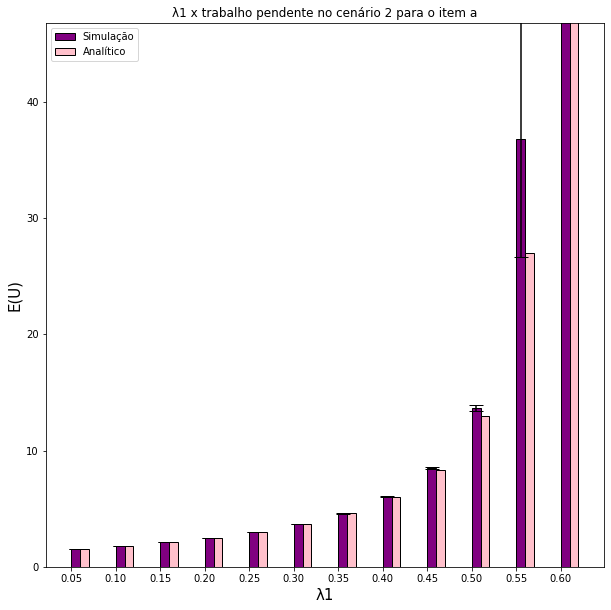

In [0]:
printGraficoQ5(2,'a',resultCenario2a, 65, resultCenario2a[1][len(resultCenario2a[1])-2]+10)

##### Parte 2

In [0]:
X1_barra = X_barra(1, 0, 0, 'e')
X2_barra = X_barra(0.5, 0, 0, 'e')

Xr_barras = []
Nq1_barrasAnal = []
Nq2_barrasAnal = []
ρs = []

for lambd in range(5, 65, 5):
  λ = 0.01*lambd
  result = trabalhoPendenteCenario2_Analitico(λ, 0.2, 1, 0.5)
  Nq1, Nq2 = NqAnaliticoCenario2(λ, 0.2, 1, 0.5, False)

  Nq1_barrasAnal.append(Nq1)
  Nq2_barrasAnal.append(Nq2)
  Xr_barras.append(result[1])
  ρs.append(result[2])

intConfMax = [ (resultCenario2a[4][i] + resultCenario2a[5][i])*X1_barra + (resultCenario2a[6][i] + resultCenario2a[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2a[0]))  ]
intConfMin = [ (resultCenario2a[4][i] - resultCenario2a[5][i])*X1_barra + (resultCenario2a[6][i] - resultCenario2a[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2a[0]))  ]

ladoDirEq3Simu = [ f"{round(resultCenario2a[4][i]*X1_barra + resultCenario2a[6][i]*X2_barra + ρs[i]*Xr_barras[i],5)}; ({round(intConfMin[i],5)}, {round(intConfMax[i],5)})" for i in range(len(resultCenario2a[0])) ]

ladoDirEq3Anal = [ Nq1_barrasAnal[i]*X1_barra + Nq2_barrasAnal[i]*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2a[0])) ]

tabelaComparacao1 = PrettyTable()

nomes_colunasComp1 = ['λ1', 'E(U) = (ρ*Xr)/(1-ρ) - Simulação', 'E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico', 'E(Nq1); (Intervalo de confiança) - Simulação', 'E(Nq2); (Intervalo de confiança) - Simulação','E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação']

tabelaComparacao1.add_column(nomes_colunasComp1[0], [ round(lambd,2) for lambd in resultCenario2a[0] ])
tabelaComparacao1.add_column(nomes_colunasComp1[1], [ f"{round(resultCenario2a[1][i],5)}; ({round(resultCenario2a[1][i]-resultCenario2a[3][i],5)}, {round(resultCenario2a[1][i]+resultCenario2a[3][i],5)})" for i in range(len(resultCenario2a[1])) ])
tabelaComparacao1.add_column(nomes_colunasComp1[2], [ round(ladoDirEq3Anal[i],5) for i in range(len(ladoDirEq3Anal)) ])
tabelaComparacao1.add_column(nomes_colunasComp1[3], [ f"{round(resultCenario2a[4][i],5)}; ({round(resultCenario2a[4][i]-resultCenario2a[5][i],5)}, {round(resultCenario2a[4][i]+resultCenario2a[5][i],5)})" for i in range(len(resultCenario2a[4])) ])
tabelaComparacao1.add_column(nomes_colunasComp1[4], [ f"{round(resultCenario2a[6][i],5)}; ({round(resultCenario2a[6][i]-resultCenario2a[7][i],5)}, {round(resultCenario2a[6][i]+resultCenario2a[7][i],5)})" for i in range(len(resultCenario2a[6])) ])
tabelaComparacao1.add_column(nomes_colunasComp1[5], [ ladoDirEq3Simu[i] for i in range(len(ladoDirEq3Simu)) ])

print(tabelaComparacao1)

+------+----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
|  λ1  | E(U) = (ρ*Xr)/(1-ρ) - Simulação  | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico | E(Nq1); (Intervalo de confiança) - Simulação | E(Nq2); (Intervalo de confiança) - Simulação | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação |
+------+----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
| 0.05 |     1.5455; (1.5418, 1.5492)     |                     1.50335                     |         0.01686; (0.01637, 0.01734)          |         0.29117; (0.28777, 0.29458)          |            1.4492; (1.44191, 1.4565)            |
| 0.1  |    1.80022; (1.79564, 1.8048)    |     

#### Cenário 3

##### Parte 1

In [0]:
from prettytable import PrettyTable

def deterministica(L):
  return 1/L

def simulaCenario3a():
  
  medias_U = []
  medias_UAnalitico = []
  confsU = []

  medias_Nq1 = []
  confsNq1 = []

  medias_Nq2 = []
  confsNq2 = []
  
  λs = []
    
  resultCenario3a = []
  for i in range(5, 65, 5): # Para cada λ1 do cenário 1 
    λ = 0.01 * i  # Gera o λ1  
    λs.append(λ) # Guarda os λ num array

    result = simulaGerala(λ , 0.2, 1, 0.5, 1000, deterministica) # Faz a simulação para cada λ
  
    medias_U.append(result[0])
   
    medias_UAnalitico.append(trabalhoPendenteCenario3_Analitico(λ, 0.2, 1, 0.5)[0])
    
    confsU.append(result[0] - result[1][0])

    medias_Nq1.append(result[2])

    confsNq1.append(result[2] - result[3][0])

    medias_Nq2.append(result[4])

    confsNq2.append(result[4] - result[5][0])
  
  # Salva tudo num array geral
  resultCenario3a.append(λs)
  resultCenario3a.append(medias_U)
  resultCenario3a.append(medias_UAnalitico)
  resultCenario3a.append(confsU)
  resultCenario3a.append(medias_Nq1)
  resultCenario3a.append(confsNq1)
  resultCenario3a.append(medias_Nq2)
  resultCenario3a.append(confsNq2)


  return resultCenario3a


resultCenario3a = simulaCenario3a()


# Tabela 1
tabela1Cenario3 = PrettyTable()
nomes_colunas = ['λ', 'Simulação: E[U]; (Intervalo de confiança)', 'Analítico: E[U]']

tabela1Cenario3.add_column(nomes_colunas[0], [ round(lambd,2) for lambd in resultCenario3a[0] ])
tabela1Cenario3.add_column(nomes_colunas[1], [ f"{round(resultCenario3a[1][i],5)}; ({round(resultCenario3a[1][i]-resultCenario3a[3][i],5)}, {round(resultCenario3a[1][i]+resultCenario3a[3][i],5)})" for i in range(len(resultCenario3a[1])) ])
tabela1Cenario3.add_column(nomes_colunas[2], [ round(item,5) for item in resultCenario3a[2] ])


print(tabela1Cenario3.get_string(title="Resultados do Cenário 3a - Simulação e solução analítica"))

+------+-------------------------------------------+-----------------+
|  λ   | Simulação: E[U]; (Intervalo de confiança) | Analítico: E[U] |
+------+-------------------------------------------+-----------------+
| 0.05 |        0.77297; (0.77169, 0.77425)        |     0.77273     |
| 0.1  |        0.90022; (0.89855, 0.90189)        |       0.9       |
| 0.15 |         1.05532; (1.05304, 1.0576)        |     1.05556     |
| 0.2  |         1.24941; (1.24632, 1.2525)        |       1.25      |
| 0.25 |        1.50352; (1.49919, 1.50785)        |       1.5       |
| 0.3  |        1.83818; (1.83179, 1.84457)        |     1.83333     |
| 0.35 |        2.30321; (2.29323, 2.31319)        |       2.3       |
| 0.4  |        3.00642; (2.99021, 3.02264)        |       3.0       |
| 0.45 |        4.18859; (4.15641, 4.22077)        |     4.16667     |
| 0.5  |        6.56092; (6.48559, 6.63626)        |       6.5       |
| 0.55 |       15.26565; (14.26287, 16.26843)      |       13.5      |
| 0.6 

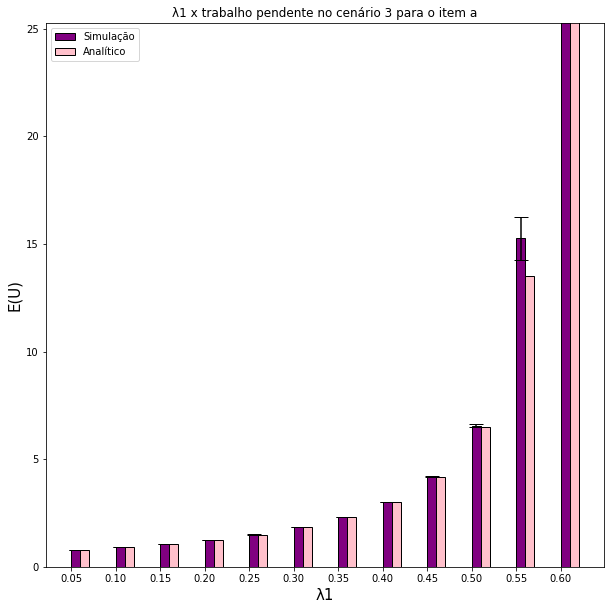

In [0]:
printGraficoQ5(3,'a',resultCenario3a,65, resultCenario3a[1][len(resultCenario3a[1])-2]+10)

##### Parte 2

In [0]:
X1_barra = X_barra(1, 0, 0, 'd')
X2_barra = X_barra(0.5, 0, 0, 'd')

Xr_barras = []
Nq1_barrasAnal = []
Nq2_barrasAnal = []
ρs = []

for lambd in range(5, 65, 5):
  λ = 0.01*lambd
  result = trabalhoPendenteCenario3_Analitico(λ, 0.2, 1, 0.5)
  Nq1, Nq2 = NqAnaliticoCenario3(λ, 0.2, 1, 0.5, False)

  Nq1_barrasAnal.append(Nq1)
  Nq2_barrasAnal.append(Nq2)
  Xr_barras.append(result[1])
  ρs.append(result[2])

intConfMax = [ (resultCenario3a[4][i] + resultCenario3a[5][i])*X1_barra + (resultCenario3a[6][i] + resultCenario3a[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3a[0]))  ]
intConfMin = [ (resultCenario3a[4][i] - resultCenario3a[5][i])*X1_barra + (resultCenario3a[6][i] - resultCenario3a[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3a[0]))  ]

ladoDirEq3Simu = [ f"{round(resultCenario3a[4][i]*X1_barra + resultCenario3a[6][i]*X2_barra + ρs[i]*Xr_barras[i],5)}; ({round(intConfMin[i],5)}, {round(intConfMax[i],5)})" for i in range(len(resultCenario3a[0])) ]

ladoDirEq3Anal = [ Nq1_barrasAnal[i]*X1_barra + Nq2_barrasAnal[i]*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3a[0])) ]

tabelaComparacao2 = PrettyTable()

nomes_colunasComp2 = ['λ1', 'E(U) = (ρ*Xr)/(1-ρ) - Simulação', 'E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico', 'E(Nq1); (Intervalo de confiança) - Simulação', 'E(Nq2); (Intervalo de confiança) - Simulação','E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação']

tabelaComparacao2.add_column(nomes_colunasComp2[0], [ round(lambd,2) for lambd in resultCenario3a[0] ])
tabelaComparacao2.add_column(nomes_colunasComp2[1], [ f"{round(resultCenario3a[1][i],5)}; ({round(resultCenario3a[1][i]-resultCenario3a[3][i],5)}, {round(resultCenario3a[1][i]+resultCenario3a[3][i],5)})" for i in range(len(resultCenario3a[1])) ])
tabelaComparacao2.add_column(nomes_colunasComp2[2], [ round(ladoDirEq3Anal[i],5) for i in range(len(ladoDirEq3Anal)) ])
tabelaComparacao2.add_column(nomes_colunasComp2[3], [ f"{round(resultCenario3a[4][i],5)}; ({round(resultCenario3a[4][i]-resultCenario3a[5][i],5)}, {round(resultCenario3a[4][i]+resultCenario3a[5][i],5)})" for i in range(len(resultCenario3a[4])) ])
tabelaComparacao2.add_column(nomes_colunasComp2[4], [ f"{round(resultCenario3a[6][i],5)}; ({round(resultCenario3a[6][i]-resultCenario3a[7][i],5)}, {round(resultCenario3a[6][i]+resultCenario3a[7][i],5)})" for i in range(len(resultCenario3a[6])) ])
tabelaComparacao2.add_column(nomes_colunasComp2[5], [ ladoDirEq3Simu[i] for i in range(len(ladoDirEq3Simu)) ])

print(tabelaComparacao2)

+------+-----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
|  λ1  |  E(U) = (ρ*Xr)/(1-ρ) - Simulação  | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico | E(Nq1); (Intervalo de confiança) - Simulação | E(Nq2); (Intervalo de confiança) - Simulação | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação |
+------+-----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
| 0.05 |    0.77297; (0.77169, 0.77425)    |                     0.75299                     |          0.0056; (0.00545, 0.00575)          |         0.14462; (0.14332, 0.14592)          |            0.71985; (0.7171, 0.7226)            |
| 0.1  |    0.90022; (0.89855, 0.90189)    |

### Item b (Com preempção)

#### Código-base para a simulação

In [0]:
import numpy as np
import scipy as sp
import scipy.stats
import math
import time
import random
import operator
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from decimal import *

class Eventos:
  def __init__(self, tipo, fimEvento, duracaoServico):
    self.tipo = tipo
    self.fimEvento = fimEvento #Do ponto de vista do lambda é a chegada na fila e do ponto de vista de mi é o tempo de sair do servidor.
    self.duracaoServico = duracaoServico

class Cliente:
  def __init__(self, tempoResidual):
    self.tempoResidual = tempoResidual


#Simulador  
def simulaMG1b (λ1, λ2, µ1, µ2, nEventos, X = random.expovariate,  premp = False, tempoTotalSimulacao = 4000): # Simula uma fila M/G/1, retornando o E(N)
  linhaDoTempo = 0
  
  area1 = 0
  N01 = 0
  T01 = 0
  area2 = 0
  N02 = 0
  T02 = 0
  numeroTotalClienteT1 = 0
  numeroTotalClienteT2 = 0
  numeroTotalCliente = 0
  tempTotalServico = 0
  fila1 = []  #Fila1. OBS: A primeira posição NÃO representa o servidor.
  fila2 = []  #Fila2. OBS: A primeira posição NÃO representa o servidor.
  tempoResidualF1 = []
  tempoResidualF2 = []
  servidor = 0 #0 representa não ter ninguém no servidor; 1 cliente do tipo 1 e 2 cliente do tipo 2
  eventos = [] #Fila de eventos
  atualEvento = 0

  #Primeira ocorrência de eventos (λ1 e λ2)
  temp = random.expovariate(λ1)
  eventos.append(Eventos("Chegada1",temp , temp))
  if(λ2 != 0):
    temp = random.expovariate(λ2)
    eventos.append(Eventos("Chegada2", temp, temp))
  

  while(linhaDoTempo <= tempoTotalSimulacao):

    eventos.sort(key=lambda eventos: eventos.fimEvento)

    atualEvento = eventos[0] #Pega o primeiro evento
    eventos = eventos[1:] #Tira o primeiro evento da fila de eventos
    linhaDoTempo = atualEvento.fimEvento #Avança a linha do tempo

    if(atualEvento.tipo == "Chegada1"):
      fila1.append(Cliente(-1))
      temp = random.expovariate(λ1)
      eventos.append(Eventos("Chegada1", linhaDoTempo + temp, temp)) #Evento de chegada do próximo cliente do tipo 1

      if(len(fila1) == 1 and servidor == 0):
        fila1 = fila1[1:]
        servidor = 1 #Cliente do tipo 1 sendo servido
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
        tempoResidualF1.append(0)
      
      if(premp == True and len(fila1) == 1 and servidor == 2):
        fila1 = fila1[1:]
        servidor = 1
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
    
        for i in eventos:
          if(i.tipo == "Servico2"):
            fila2.append(Cliente(i.fimEvento - linhaDoTempo))
            eventos.remove(i)

    elif(atualEvento.tipo == "Chegada2"):
      fila2.append(Cliente(-1))
      temp = random.expovariate(λ2)
      eventos.append(Eventos("Chegada2", linhaDoTempo +temp, temp)) #Evento de chegada do próximo cliente do tipo 2

      if(len(fila2) == 1 and servidor == 0 and len(fila1) == 0):
        fila2 = fila2[1:]
        servidor = 2 #Cliente do tipo 2 sendo servido
        temp =  X(µ2)
        eventos.append(Eventos("Servico2", linhaDoTempo + temp, temp))

    elif(atualEvento.tipo == "Servico1" or atualEvento.tipo == "Servico2"):
      numeroTotalCliente += 1
      tempTotalServico += atualEvento.duracaoServico

      if(servidor == 1):
        numeroTotalClienteT1 += 1
      elif(servidor == 2):  
        numeroTotalClienteT2 += 1

      servidor = 0

      if(len(fila1) > 0):
        fila1 = fila1[1:]
        servidor = 1
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
      elif(len(fila2) > 0):
        if(fila2[0] != -1):
          eventos.append(Eventos("Servico2", linhaDoTempo + fila2[0].tempoResidual, temp))
        else:
          temp =  X(µ2)
          eventos.append(Eventos("Servico2", linhaDoTempo + temp, temp))
        fila2 = fila2[1:]
        servidor = 2
 
    if(len(fila1) != N01):
      if(N01 > 0 ):
        area1 = area1 + (N01-1)*(linhaDoTempo - T01)

      N01 = len(fila1)
      T01 = linhaDoTempo

    if(len(fila2) != N02):
      if(N02 > 0 ):
        area2 = area2 + (N02-1)*(linhaDoTempo - T02)

      N02 = len(fila2)
      T02 = linhaDoTempo
  
  return area1/linhaDoTempo, area2/linhaDoTempo, (tempTotalServico/numeroTotalClienteT1), (tempTotalServico/numeroTotalClienteT2), numeroTotalCliente, (tempTotalServico/linhaDoTempo)  #Retorna [Nq1],[Nq2], [X1], [X2], Número total de clientes servidos, ρ,

#Chama o simulador diversas vezes e gera a média dos resultados
def simulaGeralb(λ1, λ2, µ1, µ2, nSimulacoes, X = random.expovariate):
  # Array para o resultado de cada uma das simulações
  Nq1_barras = []
  Nq2_barras = []
  X1_barras = []
  X2_barras = []
  T1_barras = []
  T2_barras = []
  W1_barras = []
  W2_barras = []
  Xr_barra = []
  TotaisClienteServidos = [] 
  ρ_s = []
  U_barras = []

  # Médias das simulações
  media_simus_Nq = 0
  media_simus_W = 0
  media_simus_X = 0
  media_simus_N = 0
  media_simus_ρ = 0
  media_simus_T = 0
  media_simus_U = 0
  
  desvio_simus_Nq = 0
  desvio_simus_W = 0
  desvio_simus_X = 0
  desvio_simus_N = 0
  desvio_simus_ρ = 0
  desvio_simus_T = 0
  desvio_simus_U = 0

  for i in range(nSimulacoes): #Realiza n Simulacões.
    NQ1_barra, NQ2_barra, X1_barra, X2_barra, totalClienteServidos, ρ = simulaMG1b(λ1, λ2, µ1, µ2, 1000, X, True) #Simulações com 1000 eventos cada
    
    Nq1_barras.append(NQ1_barra)
    Nq2_barras.append(NQ2_barra) 
    TotaisClienteServidos.append(totalClienteServidos)
    X1_barras.append(X1_barra)
    X2_barras.append(X2_barra)
    W1_barras.append(Nq1_barras[i]/(λ1))
    W2_barras.append(Nq2_barras[i]/(λ2))
    ρ_s.append(ρ)
    T1_barras.append(W1_barras[i] + X1_barras[i])
    T2_barras.append(W1_barras[i] + X1_barras[i])
    #Xr_barra = ((λ1/µ1)/ρ)*(1/µ1) + ((λ2/µ2)/ρ)*(1/µ2)
    #U_barras.append((ρ*Xr_barra)/(1-ρ))

    if(X == deterministica):
      Xr_barra = ((λ1/µ1)/ρ)*(1/(2*µ1)) + ((λ2/µ2)/ρ)*(1/(2*µ2))
      U_barras.append((ρ*Xr_barra)/(1-ρ))
    else: 
      Xr_barra = ((λ1/µ1)/ρ)*(1/µ1) + ((λ2/µ2)/ρ)*(1/µ2)
      U_barras.append((ρ*Xr_barra)/(1-ρ))

  #Média para U_barra(Trabalho pendente) de todas as simulações
  media_simus_U = np.array(U_barras).mean()
  desvio_simus_U = np.std(np.array(U_barras))
  intervaloConf_U = []
  intervaloConf_U.append(media_simus_U - 1.96*(desvio_simus_U/math.sqrt(len(U_barras))))
  intervaloConf_U.append(media_simus_U + 1.96*(desvio_simus_U/math.sqrt(len(U_barras))))

  media_simus_Nq1 = np.array(Nq1_barras).mean()
  desvio_simus_Nq1 = np.std(np.array(Nq1_barras))
  intervaloConf_Nq1 = []
  intervaloConf_Nq1.append(media_simus_Nq1 - 1.96*(desvio_simus_Nq1/math.sqrt(len(Nq1_barras))))
  intervaloConf_Nq1.append(media_simus_Nq1 + 1.96*(desvio_simus_Nq1/math.sqrt(len(Nq1_barras))))

  media_simus_Nq2 = np.array(Nq2_barras).mean()
  desvio_simus_Nq2 = np.std(np.array(Nq2_barras))
  intervaloConf_Nq2 = []
  intervaloConf_Nq2.append(media_simus_Nq2 - 1.96*(desvio_simus_Nq2/math.sqrt(len(Nq2_barras))))
  intervaloConf_Nq2.append(media_simus_Nq2 + 1.96*(desvio_simus_Nq2/math.sqrt(len(Nq2_barras))))

  return [media_simus_U, intervaloConf_U, media_simus_Nq1, intervaloConf_Nq1, media_simus_Nq2, intervaloConf_Nq2]



#### Cenário 2

##### Parte 1

In [0]:
from prettytable import PrettyTable

def simulaCenario2b():

  medias_U = []
  medias_UAnalitico = []
  confsU = []

  medias_Nq1 = []
  confsNq1 = []

  medias_Nq2 = []
  confsNq2 = []

  λs = []

  resultCenario2b = []
  for i in range(5, 65, 5): # Para cada λ1 do cenário 1 
    λ = 0.01 * i  # Gera o λ1  
    λs.append(λ) # Guarda os λ num array

    result = simulaGeralb(λ , 0.2, 1, 0.5, 1000) # Faz a simulação para cada λ
  
    medias_U.append(result[0])
   
    medias_UAnalitico.append(trabalhoPendenteCenario2_Analitico(λ, 0.2, 1, 0.5)[0])
    
    confsU.append(result[0] - result[1][0])

    medias_Nq1.append(result[2])

    confsNq1.append(result[2] - result[3][0])

    medias_Nq2.append(result[4])

    confsNq2.append(result[4] - result[5][0])
  
  # Salva tudo num array geral
  resultCenario2b.append(λs)
  resultCenario2b.append(medias_U)
  resultCenario2b.append(medias_UAnalitico)
  resultCenario2b.append(confsU)
  resultCenario2b.append(medias_Nq1)
  resultCenario2b.append(confsNq1)
  resultCenario2b.append(medias_Nq2)
  resultCenario2b.append(confsNq2)


  return resultCenario2b


resultCenario2b = simulaCenario2b()


# Tabela 2
tabela2Cenario2 = PrettyTable()
nomes_colunas2 = ['λ', 'Simulação: E[U]; (Intervalo de confiança)', 'Analítico: E[U]']

tabela2Cenario2.add_column(nomes_colunas2[0], [ round(lambd,2) for lambd in resultCenario2b[0] ])
tabela2Cenario2.add_column(nomes_colunas2[1], [ f"{round(resultCenario2b[1][i],5)}; ({round(resultCenario2b[1][i]-resultCenario2b[3][i],5)}, {round(resultCenario2b[1][i]+resultCenario2b[3][i],5)})" for i in range(len(resultCenario2b[1])) ])
tabela2Cenario2.add_column(nomes_colunas2[2], [ round(item,5) for item in resultCenario2b[2] ])


print(tabela2Cenario2.get_string(title="Resultados do Cenário 2b - Simulação e solução analítica"))

+------+-------------------------------------------+-----------------+
|  λ   | Simulação: E[U]; (Intervalo de confiança) | Analítico: E[U] |
+------+-------------------------------------------+-----------------+
| 0.05 |        2.58911; (2.56887, 2.60934)        |     1.54545     |
| 0.1  |        2.96697; (2.94268, 2.99127)        |       1.8       |
| 0.15 |        3.42748; (3.39527, 3.45968)        |     2.11111     |
| 0.2  |        4.02718; (3.98561, 4.06874)        |       2.5       |
| 0.25 |         4.8481; (4.78717, 4.90903)        |       3.0       |
| 0.3  |         6.03075; (5.93911, 6.1224)        |     3.66667     |
| 0.35 |        7.58084; (7.43335, 7.72832)        |       4.6       |
| 0.4  |       10.36617; (10.03992, 10.69243)      |       6.0       |
| 0.45 |       20.41876; (7.64037, 33.19715)       |     8.33333     |
| 0.5  |      48.19511; (-58.08881, 154.47903)     |       13.0      |
| 0.55 |       35.29654; (8.06394, 62.52913)       |       27.0      |
| 0.6 

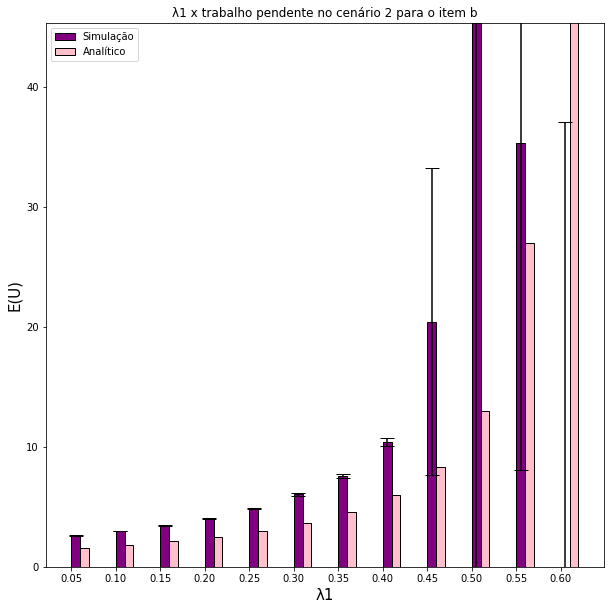

In [0]:
printGraficoQ5(2,'b',resultCenario2b,65, resultCenario2b[1][len(resultCenario2b[1])-2]+10)

##### Parte 2

In [0]:
X1_barra = X_barra(1, 0, 0, 'e')
X2_barra = X_barra(0.5, 0, 0, 'e')

Xr_barras = []
Nq1_barrasAnal = []
Nq2_barrasAnal = []
ρs = []

for lambd in range(5, 65, 5):
  λ = 0.01*lambd
  result = trabalhoPendenteCenario2_Analitico(λ, 0.2, 1, 0.5)
  Nq1, Nq2 = NqAnaliticoCenario2(λ, 0.2, 1, 0.5, True)

  Nq1_barrasAnal.append(Nq1)
  Nq2_barrasAnal.append(Nq2)
  Xr_barras.append(result[1])
  ρs.append(result[2])

intConfMax = [ (resultCenario2b[4][i] + resultCenario2b[5][i])*X1_barra + (resultCenario2b[6][i] + resultCenario2b[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2b[0]))  ]
intConfMin = [ (resultCenario2b[4][i] - resultCenario2b[5][i])*X1_barra + (resultCenario2b[6][i] - resultCenario2b[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2b[0]))  ]

ladoDirEq3Simu = [ f"{round(resultCenario2b[4][i]*X1_barra + resultCenario2b[6][i]*X2_barra + ρs[i]*Xr_barras[i],5)}; ({round(intConfMin[i],5)}, {round(intConfMax[i],5)})" for i in range(len(resultCenario2b[0])) ]

ladoDirEq3Anal = [ Nq1_barrasAnal[i]*X1_barra + Nq2_barrasAnal[i]*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2b[0])) ]

tabelaComparacao3 = PrettyTable()

nomes_colunasComp3 = ['λ1', 'E(U) = (ρ*Xr)/(1-ρ) - Simulação', 'E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico', 'E(Nq1); (Intervalo de confiança) - Simulação', 'E(Nq2); (Intervalo de confiança) - Simulação','E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação']

tabelaComparacao3.add_column(nomes_colunasComp3[0], [ round(lambd,2) for lambd in resultCenario2b[0] ])
tabelaComparacao3.add_column(nomes_colunasComp3[1], [ f"{round(resultCenario2b[1][i],5)}; ({round(resultCenario2b[1][i]-resultCenario2b[3][i],5)}, {round(resultCenario2b[1][i]+resultCenario2b[3][i],5)})" for i in range(len(resultCenario2b[1])) ])
tabelaComparacao3.add_column(nomes_colunasComp3[2], [ round(ladoDirEq3Anal[i],5) for i in range(len(ladoDirEq3Anal)) ])
tabelaComparacao3.add_column(nomes_colunasComp3[3], [ f"{round(resultCenario2b[4][i],5)}; ({round(resultCenario2b[4][i]-resultCenario2b[5][i],5)}, {round(resultCenario2b[4][i]+resultCenario2b[5][i],5)})" for i in range(len(resultCenario2b[4])) ])
tabelaComparacao3.add_column(nomes_colunasComp3[4], [ f"{round(resultCenario2b[6][i],5)}; ({round(resultCenario2b[6][i]-resultCenario2b[7][i],5)}, {round(resultCenario2b[6][i]+resultCenario2b[7][i],5)})" for i in range(len(resultCenario2b[6])) ])
tabelaComparacao3.add_column(nomes_colunasComp3[5], [ ladoDirEq3Simu[i] for i in range(len(ladoDirEq3Simu)) ])

print(tabelaComparacao3)

+------+----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
|  λ1  | E(U) = (ρ*Xr)/(1-ρ) - Simulação  | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico | E(Nq1); (Intervalo de confiança) - Simulação | E(Nq2); (Intervalo de confiança) - Simulação | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação |
+------+----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
| 0.05 |   2.58911; (2.56887, 2.60934)    |                     1.54545                     |         0.00014; (0.00012, 0.00016)          |         0.02966; (0.02925, 0.03006)          |           0.90945; (0.90862, 0.91028)           |
| 0.1  |   2.96697; (2.94268, 2.99127)    |     

#### Cenário 3

##### Parte 1

In [0]:
from prettytable import PrettyTable

def deterministica(L):
  return 1/L

def simulaCenario3b():
  
  medias_U = []
  medias_UAnalitico = []
  confsU = []
  
  medias_Nq1 = []
  confsNq1 = []

  medias_Nq2 = []
  confsNq2 = []

  λs = []
    
  resultCenario3b = []
  for i in range(5, 65, 5): # Para cada λ1 do cenário 1 
    λ = 0.01 * i  # Gera o λ1  
    λs.append(λ) # Guarda os λ num array

    result = simulaGeralb(λ , 0.2, 1, 0.5, 1000, deterministica) # Faz a simulação para cada λ
  
    medias_U.append(result[0])
   
    medias_UAnalitico.append(trabalhoPendenteCenario3_Analitico(λ, 0.2, 1, 0.5)[0])
    
    confsU.append(result[0] - result[1][0])

    medias_Nq1.append(result[2])

    confsNq1.append(result[2] - result[3][0])

    medias_Nq2.append(result[4])

    confsNq2.append(result[4] - result[5][0])
  
  # Salva tudo num array geral
  resultCenario3b.append(λs)
  resultCenario3b.append(medias_U)
  resultCenario3b.append(medias_UAnalitico)
  resultCenario3b.append(confsU)
  resultCenario3b.append(medias_Nq1)
  resultCenario3b.append(confsNq1)
  resultCenario3b.append(medias_Nq2)
  resultCenario3b.append(confsNq2)
  


  return resultCenario3b


resultCenario3b = simulaCenario3b()

# Tabela 2
tabela2Cenario3 = PrettyTable()
nomes_colunas2 = ['λ', 'Simulação: E[U]; (Intervalo de confiança)', 'Analítico: E[U]']

tabela2Cenario3.add_column(nomes_colunas2[0], [ round(lambd,2) for lambd in resultCenario3b[0] ])
tabela2Cenario3.add_column(nomes_colunas2[1], [ f"{round(resultCenario3b[1][i],5)}; ({round(resultCenario3b[1][i]-resultCenario3b[3][i],5)}, {round(resultCenario3b[1][i]+resultCenario3b[3][i],5)})" for i in range(len(resultCenario3b[1])) ])
tabela2Cenario3.add_column(nomes_colunas2[2], [ round(item,5) for item in resultCenario3b[2] ])


print(tabela2Cenario3.get_string(title="Resultados do Cenário 3b - Simulação e solução analítica"))

+------+-------------------------------------------+-----------------+
|  λ   | Simulação: E[U]; (Intervalo de confiança) | Analítico: E[U] |
+------+-------------------------------------------+-----------------+
| 0.05 |         1.33688; (1.32865, 1.3451)        |     0.77273     |
| 0.1  |        1.71957; (1.70637, 1.73276)        |       0.9       |
| 0.15 |        2.33092; (2.30494, 2.35689)        |     1.05556     |
| 0.2  |        3.36191; (3.30247, 3.42136)        |       1.25      |
| 0.25 |         3.19221; (-0.85758, 7.242)        |       1.5       |
| 0.3  |       11.58757; (6.45408, 16.72106)       |     1.83333     |
| 0.35 |      -15.74072; (-73.82097, 42.33952)     |       2.3       |
| 0.4  |      -14.68336; (-39.50556, 10.13884)     |       3.0       |
| 0.45 |     315.52933; (-301.34854, 932.40721)    |     4.16667     |
| 0.5  |       -7.38063; (-8.71436, -6.04689)      |       6.5       |
| 0.55 |       -5.01275; (-5.12305, -4.90244)      |       13.5      |
| 0.6 

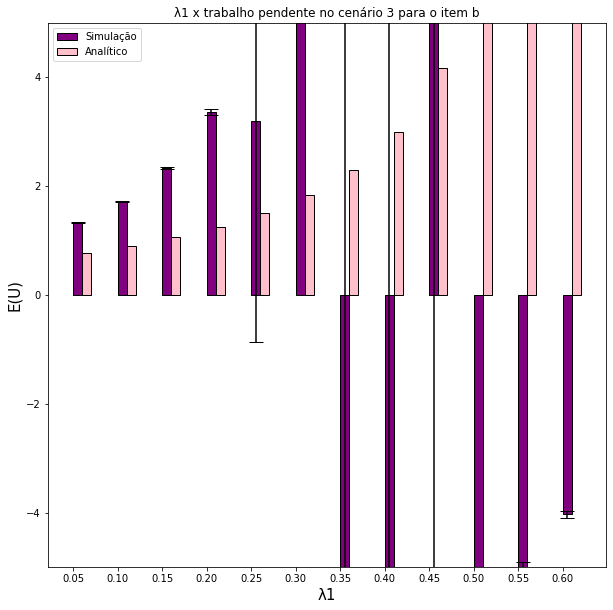

In [0]:
printGraficoQ5(3,'b',resultCenario3b,65, resultCenario3b[1][len(resultCenario3b[1])-2]+10)

##### Parte 2

In [0]:
X1_barra = X_barra(1, 0, 0, 'd')
X2_barra = X_barra(0.5, 0, 0, 'd')

Xr_barras = []
Nq1_barrasAnal = []
Nq2_barrasAnal = []
ρs = []

for lambd in range(5, 65, 5):
  λ = 0.01*lambd
  result = trabalhoPendenteCenario3_Analitico(λ, 0.2, 1, 0.5)
  Nq1, Nq2 = NqAnaliticoCenario2(λ, 0.2, 1, 0.5, True)

  Nq1_barrasAnal.append(Nq1)
  Nq2_barrasAnal.append(Nq2)
  Xr_barras.append(result[1])
  ρs.append(result[2])

intConfMax = [ (resultCenario3b[4][i] + resultCenario3b[5][i])*X1_barra + (resultCenario3b[6][i] + resultCenario3b[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3b[0]))  ]
intConfMin = [ (resultCenario3b[4][i] - resultCenario3b[5][i])*X1_barra + (resultCenario3b[6][i] - resultCenario3b[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3b[0]))  ]

ladoDirEq3Simu = [ f"{round(resultCenario3b[4][i]*X1_barra + resultCenario3b[6][i]*X2_barra + ρs[i]*Xr_barras[i],5)}; ({round(intConfMin[i],5)}, {round(intConfMax[i],5)})" for i in range(len(resultCenario3b[0])) ]

ladoDirEq3Anal = [ Nq1_barrasAnal[i]*X1_barra + Nq2_barrasAnal[i]*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3b[0])) ]

tabelaComparacao4 = PrettyTable()

nomes_colunasComp4 = ['λ1', 'E(U) = (ρ*Xr)/(1-ρ) - Simulação', 'E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico', 'E(Nq1); (Intervalo de confiança) - Simulação', 'E(Nq2); (Intervalo de confiança) - Simulação','E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação']

tabelaComparacao4.add_column(nomes_colunasComp4[0], [ round(lambd,2) for lambd in resultCenario3b[0] ])
tabelaComparacao4.add_column(nomes_colunasComp4[1], [ f"{round(resultCenario3b[1][i],5)}; ({round(resultCenario3b[1][i]-resultCenario3b[3][i],5)}, {round(resultCenario3b[1][i]+resultCenario3b[3][i],5)})" for i in range(len(resultCenario3b[1])) ])
tabelaComparacao4.add_column(nomes_colunasComp4[2], [ round(ladoDirEq3Anal[i],5) for i in range(len(ladoDirEq3Anal)) ])
tabelaComparacao4.add_column(nomes_colunasComp4[3], [ f"{round(resultCenario3b[4][i],5)}; ({round(resultCenario3b[4][i]-resultCenario3b[5][i],5)}, {round(resultCenario3b[4][i]+resultCenario3b[5][i],5)})" for i in range(len(resultCenario3b[4])) ])
tabelaComparacao4.add_column(nomes_colunasComp4[4], [ f"{round(resultCenario3b[6][i],5)}; ({round(resultCenario3b[6][i]-resultCenario3b[7][i],5)}, {round(resultCenario3b[6][i]+resultCenario3b[7][i],5)})" for i in range(len(resultCenario3b[6])) ])
tabelaComparacao4.add_column(nomes_colunasComp4[5], [ ladoDirEq3Simu[i] for i in range(len(ladoDirEq3Simu)) ])

print(tabelaComparacao4)

+------+------------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
|  λ1  |  E(U) = (ρ*Xr)/(1-ρ) - Simulação   | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico | E(Nq1); (Intervalo de confiança) - Simulação | E(Nq2); (Intervalo de confiança) - Simulação | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação |
+------+------------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
| 0.05 |     1.33688; (1.32865, 1.3451)     |                     1.12045                     |            2e-05; (2e-05, 3e-05)             |         0.00925; (0.00915, 0.00935)          |           0.44352; (0.44331, 0.44373)           |
| 0.1  |    1.71957; (1.70637, 1.73276) 

### Item c (Sem preempção)

#### Código-base para a simulação

In [0]:
import numpy as np
import scipy as sp
import scipy.stats
import math
import time
import random
import operator
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from decimal import *

class Eventos:
  def __init__(self, tipo, fimEvento, duracaoServico):
    self.tipo = tipo
    self.fimEvento = fimEvento #Do ponto de vista do lambda é a chegada na fila e do ponto de vista de mi é o tempo de sair do servidor.
    self.duracaoServico = duracaoServico

 
#Simulador  
def simulaMG1c (λ1, λ2, µ1, µ2, nEventos, X = random.expovariate, tempoTotalSimulacao = 4000): # Simula uma fila M/G/1, retornando o E(N)
  linhaDoTempo = 0
  
  area1 = 0
  N01 = 0
  T01 = 0
  area2 = 0
  N02 = 0
  T02 = 0
  numeroTotalClienteT1 = 0
  numeroTotalClienteT2 = 0
  numeroTotalCliente = 0
  tempTotalServico = 0
  fila1 = []  #Fila1. OBS: A primeira posição NÃO representa o servidor.
  fila2 = []  #Fila2. OBS: A primeira posição NÃO representa o servidor.
  tempoResidualF1 = []
  tempoResidualF2 = []
  servidor = 0 #0 representa não ter ninguém no servidor; 1 cliente do tipo 1 e 2 cliente do tipo 2
  eventos = [] #Fila de eventos
  atualEvento = 0

  #Primeira ocorrência de eventos (λ1 e λ2)
  temp = random.expovariate(λ1)
  eventos.append(Eventos("Chegada1",temp , temp))
  if(λ2 != 0):
    temp = random.expovariate(λ2)
    eventos.append(Eventos("Chegada2", temp, temp))
  

  while(linhaDoTempo <= tempoTotalSimulacao):

    eventos.sort(key=lambda eventos: eventos.fimEvento)

    atualEvento = eventos[0] #Pega o primeiro evento
    eventos = eventos[1:] #Tira o primeiro evento da fila de eventos
    linhaDoTempo = atualEvento.fimEvento #Avança a linha do tempo

    if(atualEvento.tipo == "Chegada1"):
      fila1.append(1)
      temp = random.expovariate(λ1)
      eventos.append(Eventos("Chegada1", linhaDoTempo + temp, temp))

      if(len(fila1) == 1 and servidor == 0):
        fila1 = fila1[1:]
        servidor = 1
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
        tempoResidualF1.append(0)

    elif(atualEvento.tipo == "Chegada2"):
      fila2.append(2)
      temp = random.expovariate(λ2)
      eventos.append(Eventos("Chegada2", linhaDoTempo +temp, temp))

      if(len(fila2) == 1 and servidor == 0 and len(fila1) == 0):
        fila2 = fila2[1:]
        servidor = 2
        temp =  X(µ2)
        eventos.append(Eventos("Servico2", linhaDoTempo + temp, temp))

    elif(atualEvento.tipo == "Servico1" or atualEvento.tipo == "Servico2"):
      numeroTotalCliente += 1
      tempTotalServico += atualEvento.duracaoServico

      if(servidor == 1):
        numeroTotalClienteT1 += 1
      elif(servidor == 2):  
        numeroTotalClienteT2 += 1

      servidor = 0

      if(len(fila1) > 0):
        fila1 = fila1[1:]
        servidor = 1
        temp =  X(µ1)
        eventos.append(Eventos("Servico1", linhaDoTempo + temp, temp))
      elif(len(fila2) > 0):
        fila2 = fila2[1:]
        servidor = 2
        temp =  X(µ2)
        eventos.append(Eventos("Servico2", linhaDoTempo + temp, temp))
 
    if(len(fila1) != N01):
      if(N01 > 0 ):
        area1 = area1 + (N01-1)*(linhaDoTempo - T01)

      N01 = len(fila1)
      T01 = linhaDoTempo

    if(len(fila2) != N02):
      if(N02 > 0 ):
        area2 = area2 + (N02-1)*(linhaDoTempo - T02)

      N02 = len(fila2)
      T02 = linhaDoTempo
  
  return area1/linhaDoTempo, area2/linhaDoTempo, (tempTotalServico/numeroTotalClienteT1), (tempTotalServico/numeroTotalClienteT2), numeroTotalCliente, (tempTotalServico/linhaDoTempo)  #Retorna [Nq1],[Nq2], [X1], [X2], Número total de clientes servidos, ρ,

#Chama o simulador diversas vezes e gera a média dos resultados
def simulaGeralc(λ1, λ2, µ1, µ2, nSimulacoes, X = random.expovariate):
  # Array para o resultado de cada uma das simulações
  Nq1_barras = []
  Nq2_barras = []
  X1_barras = []
  X2_barras = []
  W1_barras = []
  W2_barras = []
  T1_barras = []
  T2_barras = []
  TotaisClienteServidos = [] 
  ρ_s = []
  U_barras = []
  Xr_barra = []

  # Médias das simulações
  media_simus_Nq = 0
  media_simus_W = 0
  media_simus_X = 0
  media_simus_N = 0
  media_simus_ρ = 0
  media_simus_T = 0
  media_simus_U = 0
  
  desvio_simus_Nq = 0
  desvio_simus_W = 0
  desvio_simus_X = 0
  desvio_simus_N = 0
  desvio_simus_ρ = 0
  desvio_simus_T = 0
  desvio_simus_U = 0

  for i in range(nSimulacoes): #Realiza n Simulacões.
    NQ1_barra, NQ2_barra, X1_barra, X2_barra, totalClienteServidos, ρ = simulaMG1c(λ1, λ2, µ1, µ2, 1000, X) #Simulações com 1000 eventos cada
    
    Nq1_barras.append(NQ1_barra)
    Nq2_barras.append(NQ2_barra) 
    TotaisClienteServidos.append(totalClienteServidos)
    X1_barras.append(X1_barra)
    X2_barras.append(X2_barra)
    W1_barras.append(Nq1_barras[i]/(λ1))
    W2_barras.append(Nq2_barras[i]/(λ2))
    ρ_s.append(ρ)
    T1_barras.append(W1_barras[i] + X1_barras[i])
    T2_barras.append(W2_barras[i] + X2_barras[i])
    #Xr_barra = ((λ1/µ1)/ρ)*(1/µ1) + ((λ2/µ2)/ρ)*(1/µ2)
    #U_barras.append((ρ*Xr_barra)/(1-ρ))

    #Híbrido
    if(X == deterministica):
      Xr_barra = ((λ1/µ1)/ρ)*(1/(2*µ1)) + ((λ2/µ2)/ρ)*(1/(2*µ2))
      U_barras.append((ρ*Xr_barra)/(1-ρ))
    else: 
      Xr_barra = ((λ1/µ1)/ρ)*(1/µ1) + ((λ2/µ2)/ρ)*(1/µ2)
      U_barras.append((ρ*Xr_barra)/(1-ρ))

    #FULL Simulação
    #Xr1_barra = ((NQ1_barra/λ1)*(1-(λ1*X1_barra)))/(λ1*X1_barra) # E[Xr] = E[W](1-ρ)/ρ
    #Xr2_barra = ((NQ2_barra/λ2)*(1-(λ2*X2_barra)))/(λ2*X2_barra) 
      
    #U_barras.append(NQ1_barra*X1_barra + NQ2_barra*X2_barra + (λ1*X1_barra)*Xr1_barra + (λ2*X2_barra)*Xr2_barra) #E[U] = E[Nq1]*E[X1] + E[Nq2]*E[X2] +  ρ1*E[Xr1] + ρ2*E[Xr2]

  #Média para U_barra(Trabalho pendente) de todas as simulações
  media_simus_U = np.array(U_barras).mean()
  desvio_simus_U = np.std(np.array(U_barras))
  intervaloConf_U = []
  intervaloConf_U.append(media_simus_U - 1.96*(desvio_simus_U/math.sqrt(len(U_barras))))
  intervaloConf_U.append(media_simus_U + 1.96*(desvio_simus_U/math.sqrt(len(U_barras))))

  media_simus_Nq1 = np.array(Nq1_barras).mean()
  desvio_simus_Nq1 = np.std(np.array(Nq1_barras))
  intervaloConf_Nq1 = []
  intervaloConf_Nq1.append(media_simus_Nq1 - 1.96*(desvio_simus_Nq1/math.sqrt(len(Nq1_barras))))
  intervaloConf_Nq1.append(media_simus_Nq1 + 1.96*(desvio_simus_Nq1/math.sqrt(len(Nq1_barras))))

  media_simus_Nq2 = np.array(Nq2_barras).mean()
  desvio_simus_Nq2 = np.std(np.array(Nq2_barras))
  intervaloConf_Nq2 = []
  intervaloConf_Nq2.append(media_simus_Nq2 - 1.96*(desvio_simus_Nq2/math.sqrt(len(Nq2_barras))))
  intervaloConf_Nq2.append(media_simus_Nq2 + 1.96*(desvio_simus_Nq2/math.sqrt(len(Nq2_barras))))

  return [media_simus_U, intervaloConf_U, media_simus_Nq1, intervaloConf_Nq1, media_simus_Nq2, intervaloConf_Nq2]

#### Cenário 2

##### Parte 1

In [0]:
from prettytable import PrettyTable

def simulaCenario2c():

  medias_U = []
  medias_UAnalitico = []
  confsU = []

  medias_Nq1 = []
  confsNq1 = []

  medias_Nq2 = []
  confsNq2 = []

  λs = []

  resultCenario2c = []
  for i in range(5, 65, 5): # Para cada λ1 do cenário 1 
    λ = 0.01 * i  # Gera o λ1  
    λs.append(λ) # Guarda os λ num array

    result = simulaGeralc(λ , 0.2, 1, 0.5, 1000) # Faz a simulação para cada λ
  
    medias_U.append(result[0])
   
    medias_UAnalitico.append(trabalhoPendenteCenario2_Analitico(λ, 0.2, 1, 0.5)[0])
    
    confsU.append(result[0] - result[1][0])

    medias_Nq1.append(result[2])

    confsNq1.append(result[2] - result[3][0])

    medias_Nq2.append(result[4])

    confsNq2.append(result[4] - result[5][0])
  
  # Salva tudo num array geral
  resultCenario2c.append(λs)
  resultCenario2c.append(medias_U)
  resultCenario2c.append(medias_UAnalitico)
  resultCenario2c.append(confsU)
  resultCenario2c.append(medias_Nq1)
  resultCenario2c.append(confsNq1)
  resultCenario2c.append(medias_Nq2)
  resultCenario2c.append(confsNq2)


  return resultCenario2c

resultCenario2c = simulaCenario2c()

# Tabela 3
tabela3Cenario2 = PrettyTable()
nomes_colunas3 = ['λ', 'Simulação: E[U]; (Intervalo de confiança)', 'Analítico: E[U]']

tabela3Cenario2.add_column(nomes_colunas3[0], [ round(lambd,2) for lambd in resultCenario2c[0] ])
tabela3Cenario2.add_column(nomes_colunas3[1], [ f"{round(resultCenario2c[1][i],5)}; ({round(resultCenario2c[1][i]-resultCenario2c[3][i],5)}, {round(resultCenario2c[1][i]+resultCenario2c[3][i],5)})" for i in range(len(resultCenario2c[1])) ])
tabela3Cenario2.add_column(nomes_colunas3[2], [ round(item,5) for item in resultCenario2c[2] ])


print(tabela3Cenario2.get_string(title="Resultados do Cenário 2c - Simulação e solução analítica"))

+------+-------------------------------------------+-----------------+
|  λ   | Simulação: E[U]; (Intervalo de confiança) | Analítico: E[U] |
+------+-------------------------------------------+-----------------+
| 0.05 |         1.5474; (1.54381, 1.55098)        |     1.54545     |
| 0.1  |        1.79917; (1.79447, 1.80387)        |       1.8       |
| 0.15 |        2.11108; (2.10461, 2.11755)        |     2.11111     |
| 0.2  |        2.49895; (2.49027, 2.50762)        |       2.5       |
| 0.25 |        3.00928; (2.99698, 3.02158)        |       3.0       |
| 0.3  |        3.68554; (3.66683, 3.70425)        |     3.66667     |
| 0.35 |        4.60685; (4.57856, 4.63513)        |       4.6       |
| 0.4  |         6.0723; (6.02118, 6.12343)        |       6.0       |
| 0.45 |         8.44712; (8.3506, 8.54364)        |     8.33333     |
| 0.5  |       13.83385; (13.45194, 14.21575)      |       13.0      |
| 0.55 |       31.16886; (28.48993, 33.8478)       |       27.0      |
| 0.6 

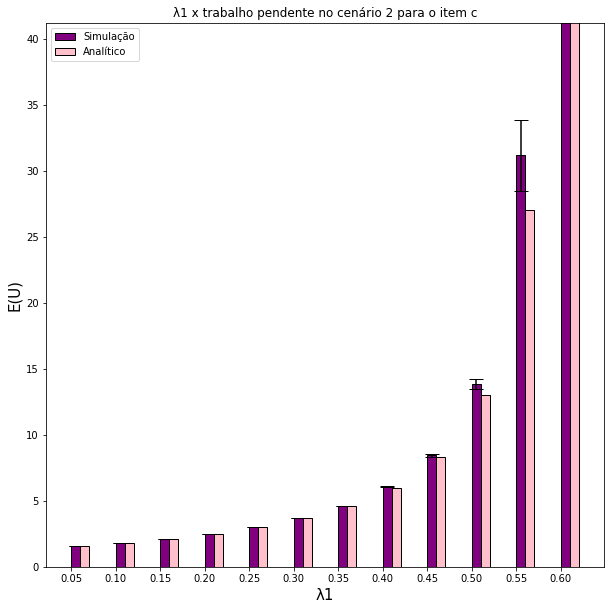

In [0]:
printGraficoQ5(2,'c',resultCenario2c,65, resultCenario2c[1][len(resultCenario2c[1])-2]+10)

##### Parte 2

In [0]:
X1_barra = X_barra(1, 0, 0, 'e')
X2_barra = X_barra(0.5, 0, 0, 'e')

Xr_barras = []
Nq1_barrasAnal = []
Nq2_barrasAnal = []
ρs = []

for lambd in range(5, 65, 5):
  λ = 0.01*lambd
  result = trabalhoPendenteCenario2_Analitico(λ, 0.2, 1, 0.5)
  Nq1, Nq2 = NqAnaliticoCenario2(λ, 0.2, 1, 0.5, False)

  Nq1_barrasAnal.append(Nq1)
  Nq2_barrasAnal.append(Nq2)
  Xr_barras.append(result[1])
  ρs.append(result[2])

intConfMax = [ (resultCenario2c[4][i] + resultCenario2c[5][i])*X1_barra + (resultCenario2c[6][i] + resultCenario2c[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2c[0]))  ]
intConfMin = [ (resultCenario2c[4][i] - resultCenario2c[5][i])*X1_barra + (resultCenario2c[6][i] - resultCenario2c[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2c[0]))  ]

ladoDirEq3Simu = [ f"{round(resultCenario2c[4][i]*X1_barra + resultCenario2c[6][i]*X2_barra + ρs[i]*Xr_barras[i],5)}; ({round(intConfMin[i],5)}, {round(intConfMax[i],5)})" for i in range(len(resultCenario2c[0])) ]

ladoDirEq3Anal = [ Nq1_barrasAnal[i]*X1_barra + Nq2_barrasAnal[i]*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario2c[0])) ]

tabelaComparacao5 = PrettyTable()

nomes_colunasComp5 = ['λ1', 'E(U) = (ρ*Xr)/(1-ρ) - Simulação', 'E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico', 'E(Nq1); (Intervalo de confiança) - Simulação', 'E(Nq2); (Intervalo de confiança) - Simulação','E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação']

tabelaComparacao5.add_column(nomes_colunasComp5[0], [ round(lambd,2) for lambd in resultCenario2c[0] ])
tabelaComparacao5.add_column(nomes_colunasComp5[1], [ f"{round(resultCenario2c[1][i],5)}; ({round(resultCenario2c[1][i]-resultCenario2c[3][i],5)}, {round(resultCenario2c[1][i]+resultCenario2c[3][i],5)})" for i in range(len(resultCenario2c[1])) ])
tabelaComparacao5.add_column(nomes_colunasComp5[2], [ round(ladoDirEq3Anal[i],5) for i in range(len(ladoDirEq3Anal)) ])
tabelaComparacao5.add_column(nomes_colunasComp5[3], [ f"{round(resultCenario2c[4][i],5)}; ({round(resultCenario2c[4][i]-resultCenario2c[5][i],5)}, {round(resultCenario2c[4][i]+resultCenario2c[5][i],5)})" for i in range(len(resultCenario2c[4])) ])
tabelaComparacao5.add_column(nomes_colunasComp5[4], [ f"{round(resultCenario2c[6][i],5)}; ({round(resultCenario2c[6][i]-resultCenario2c[7][i],5)}, {round(resultCenario2c[6][i]+resultCenario2c[7][i],5)})" for i in range(len(resultCenario2c[6])) ])
tabelaComparacao5.add_column(nomes_colunasComp5[5], [ ladoDirEq3Simu[i] for i in range(len(ladoDirEq3Simu)) ])

print(tabelaComparacao5)

+------+-----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
|  λ1  |  E(U) = (ρ*Xr)/(1-ρ) - Simulação  | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico | E(Nq1); (Intervalo de confiança) - Simulação | E(Nq2); (Intervalo de confiança) - Simulação | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação |
+------+-----------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
| 0.05 |     1.5474; (1.54381, 1.55098)    |                     1.50335                     |         0.00407; (0.00392, 0.00423)          |         0.13873; (0.13608, 0.14138)          |            1.13154; (1.12608, 1.137)            |
| 0.1  |    1.79917; (1.79447, 1.80387)    |

#### Cenário 3

##### Parte 1

In [38]:
from prettytable import PrettyTable

def deterministica(L):
  return 1/L

def simulaCenario3c():
  
  medias_U = []
  medias_UAnalitico = []
  confsU = []

  medias_Nq1 = []
  confsNq1 = []

  medias_Nq2 = []
  confsNq2 = []
  
  λs = []
    
  resultCenario3c = []
  for i in range(5, 65, 5): # Para cada λ1 do cenário 1 
    λ = 0.01 * i  # Gera o λ1  
    λs.append(λ) # Guarda os λ num array

    result = simulaGeralc(λ , 0.2, 1, 0.5, 1000, deterministica) # Faz a simulação para cada λ
  
    medias_U.append(result[0])
   
    medias_UAnalitico.append(trabalhoPendenteCenario3_Analitico(λ, 0.2, 1, 0.5)[0])
    
    confsU.append(result[0] - result[1][0])

    medias_Nq1.append(result[2])

    confsNq1.append(result[2] - result[3][0])

    medias_Nq2.append(result[4])

    confsNq2.append(result[4] - result[5][0])
  
  # Salva tudo num array geral
  resultCenario3c.append(λs)
  resultCenario3c.append(medias_U)
  resultCenario3c.append(medias_UAnalitico)
  resultCenario3c.append(confsU)
  resultCenario3c.append(medias_Nq1)
  resultCenario3c.append(confsNq1)
  resultCenario3c.append(medias_Nq2)
  resultCenario3c.append(confsNq2)


  return resultCenario3c


resultCenario3c = simulaCenario3c()

# Tabela 3
tabela3Cenario3 = PrettyTable()
nomes_colunas3 = ['λ', 'Simulação: E[U]; (Intervalo de confiança)', 'Analítico: E[U]']

tabela3Cenario3.add_column(nomes_colunas3[0], [ round(lambd,2) for lambd in resultCenario3c[0] ])
tabela3Cenario3.add_column(nomes_colunas3[1], [ f"{round(resultCenario3c[1][i],5)}; ({round(resultCenario3c[1][i]-resultCenario3c[3][i],5)}, {round(resultCenario3c[1][i]+resultCenario3c[3][i],5)})" for i in range(len(resultCenario3c[1])) ])
tabela3Cenario3.add_column(nomes_colunas3[2], [ round(item,5) for item in resultCenario3c[2] ])


print(tabela3Cenario3.get_string(title="Resultados do Cenário 3c - Simulação e solução analítica"))

+------+-------------------------------------------+-----------------+
|  λ   | Simulação: E[U]; (Intervalo de confiança) | Analítico: E[U] |
+------+-------------------------------------------+-----------------+
| 0.05 |         0.7719; (0.77063, 0.77317)        |     0.77273     |
| 0.1  |        0.90036; (0.89859, 0.90212)        |       0.9       |
| 0.15 |        1.05595; (1.05372, 1.05819)        |     1.05556     |
| 0.2  |        1.25148; (1.24832, 1.25464)        |       1.25      |
| 0.25 |        1.49949; (1.49531, 1.50366)        |       1.5       |
| 0.3  |        1.83644; (1.83013, 1.84274)        |     1.83333     |
| 0.35 |        2.30106; (2.29139, 2.31073)        |       2.3       |
| 0.4  |        3.00809; (2.99176, 3.02442)        |       3.0       |
| 0.45 |         4.1775; (4.14621, 4.20879)        |     4.16667     |
| 0.5  |         6.67383; (6.5892, 6.75846)        |       6.5       |
| 0.55 |       14.80952; (14.10566, 15.51337)      |       13.5      |
| 0.6 

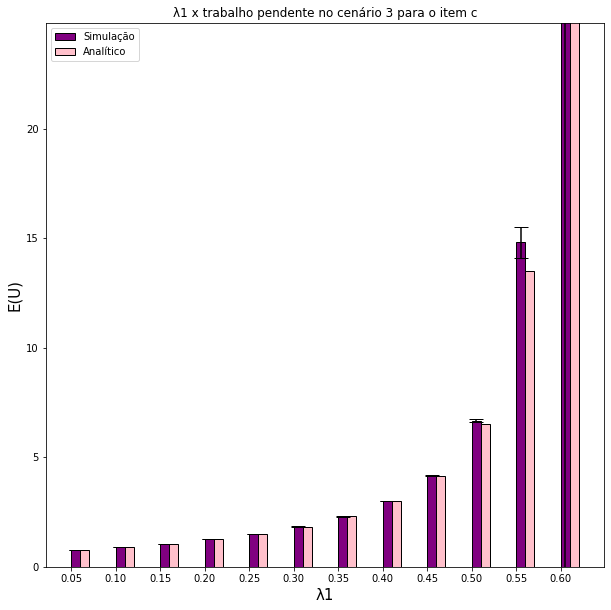

In [39]:
printGraficoQ5(3,'c',resultCenario3c,65, resultCenario3c[1][len(resultCenario3c[1])-2]+10)

##### Parte 2

In [40]:
X1_barra = X_barra(1, 0, 0, 'd')
X2_barra = X_barra(0.5, 0, 0, 'd')

Xr_barras = []
Nq1_barrasAnal = []
Nq2_barrasAnal = []
ρs = []

for lambd in range(5, 65, 5):
  λ = 0.01*lambd
  result = trabalhoPendenteCenario3_Analitico(λ, 0.2, 1, 0.5)
  Nq1, Nq2 = NqAnaliticoCenario2(λ, 0.2, 1, 0.5, False)

  Nq1_barrasAnal.append(Nq1)
  Nq2_barrasAnal.append(Nq2)
  Xr_barras.append(result[1])
  ρs.append(result[2])

intConfMax = [ (resultCenario3c[4][i] + resultCenario3c[5][i])*X1_barra + (resultCenario3c[6][i] + resultCenario3c[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3c[0]))  ]
intConfMin = [ (resultCenario3c[4][i] - resultCenario3c[5][i])*X1_barra + (resultCenario3c[6][i] - resultCenario3c[7][i])*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3c[0]))  ]

ladoDirEq3Simu = [ f"{round(resultCenario3c[4][i]*X1_barra + resultCenario3c[6][i]*X2_barra + ρs[i]*Xr_barras[i],5)}; ({round(intConfMin[i],5)}, {round(intConfMax[i],5)})" for i in range(len(resultCenario3c[0])) ]

ladoDirEq3Anal = [ Nq1_barrasAnal[i]*X1_barra + Nq2_barrasAnal[i]*X2_barra + ρs[i]*Xr_barras[i] for i in range(len(resultCenario3c[0])) ]

tabelaComparacao6 = PrettyTable()

nomes_colunasComp6 = ['λ1', 'E(U) = (ρ*Xr)/(1-ρ) - Simulação', 'E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico', 'E(Nq1); (Intervalo de confiança) - Simulação', 'E(Nq2); (Intervalo de confiança) - Simulação','E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação']

tabelaComparacao6.add_column(nomes_colunasComp6[0], [ round(lambd,2) for lambd in resultCenario3c[0] ])
tabelaComparacao6.add_column(nomes_colunasComp6[1], [ f"{round(resultCenario3c[1][i],5)}; ({round(resultCenario3c[1][i]-resultCenario3c[3][i],5)}, {round(resultCenario3c[1][i]+resultCenario3c[3][i],5)})" for i in range(len(resultCenario3c[1])) ])
tabelaComparacao6.add_column(nomes_colunasComp6[2], [ round(ladoDirEq3Anal[i],5) for i in range(len(ladoDirEq3Anal)) ])
tabelaComparacao6.add_column(nomes_colunasComp6[3], [ f"{round(resultCenario3c[4][i],5)}; ({round(resultCenario3c[4][i]-resultCenario3c[5][i],5)}, {round(resultCenario3c[4][i]+resultCenario3c[5][i],5)})" for i in range(len(resultCenario3c[4])) ])
tabelaComparacao6.add_column(nomes_colunasComp6[4], [ f"{round(resultCenario3c[6][i],5)}; ({round(resultCenario3c[6][i]-resultCenario3c[7][i],5)}, {round(resultCenario3c[6][i]+resultCenario3c[7][i],5)})" for i in range(len(resultCenario3c[6])) ])
tabelaComparacao6.add_column(nomes_colunasComp6[5], [ ladoDirEq3Simu[i] for i in range(len(ladoDirEq3Simu)) ])

print(tabelaComparacao6)

+------+--------------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
|  λ1  |   E(U) = (ρ*Xr)/(1-ρ) - Simulação    | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Analítico | E(Nq1); (Intervalo de confiança) - Simulação | E(Nq2); (Intervalo de confiança) - Simulação | E[Nq1]E[X1] + E[Nq2]E[X2] + ρE[Xr] - Simulação |
+------+--------------------------------------+-------------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+
| 0.05 |      0.7719; (0.77063, 0.77317)      |                     1.07835                     |         0.00075; (0.00072, 0.00078)          |         0.03805; (0.03735, 0.03875)          |           0.50185; (0.50041, 0.50328)           |
| 0.1  |     0.90036; (0.89859, 